**BME599 - Advanced Topics of MRI**

Department of Biomedical Engineering

University of Michigan at Ann Arbor

* Lecture: Compressed Sensing and Low-Rank Models
* Author: Zhengguo Tan <zgtan@med.umich.edu>

## Clone the repository

In [1]:
!git clone https://github.com/ZhengguoTan/teach_umich_bme599_advanced-topics-mri.git

Cloning into 'teach_umich_bme599_advanced-topics-mri'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 177 (delta 88), reused 173 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (177/177), 38.24 MiB | 20.29 MiB/s, done.
Resolving deltas: 100% (88/88), done.


## Install sigpy

In [2]:
!git clone https://github.com/ZhengguoTan/sigpy.git

Cloning into 'sigpy'...
remote: Enumerating objects: 6723, done.
remote: Counting objects: 100% (2045/2045), done.
remote: Compressing objects: 100% (273/273), done.
remote: Total 6723 (delta 1828), reused 1873 (delta 1771), pack-reused 4678 (from 2)
Receiving objects: 100% (6723/6723), 3.85 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (4953/4953), done.


In [3]:
!pip install PyWavelets

In [4]:
%cd /content/sigpy
!git log -1
!pip install -e /content/sigpy

/content/sigpy
commit 29462b5484d763c4d8be4f8af04c1e9af6993393 (HEAD -> master, origin/master, origin/HEAD)
Author: Zhengguo Tan <zhengguo.tan@gmail.com>
Date:   Mon Sep 29 15:44:04 2025 -0400

    allows for multiple sets of coils in EspiritCalib
Obtaining file:///content/sigpy
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sigpy (pyproject.toml) ... done
  Created wheel for sigpy: filename=sigpy-0.1.26-0.editable-py3-none-any.whl size=5252 sha256=9fd004998e915e5e96bcfe39ba72f316f611e1ca062a5321d4e8c7d89bc9e75f
  Stored in directory: /tmp/pip-ephem-wheel-cache-p7akl_fi/wheels/be/ba/e1/02fffbc27f77590eeac7767dce86ee795c71baebdecbfb4cf7
Successfully built sigpy


In [5]:
!nvidia-smi

Tue Sep 30 15:50:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load Shepp-Logan Phantom

In [8]:
import numpy as np
import sigpy as sp
from sigpy.mri import samp

import matplotlib.pyplot as plt

device = sp.Device(0)  # if you have GPU

> phan shape:  (128, 128)


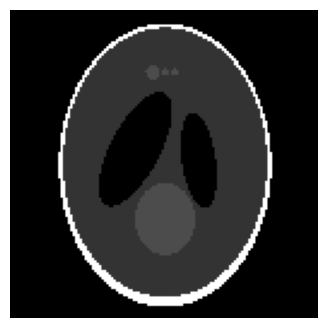

In [9]:
phan = abs(sp.shepp_logan((128, 128)))
print('> phan shape: ', phan.shape)

N_y, N_x = phan.shape

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.imshow(abs(phan), cmap='gray')
ax.set_axis_off()



## Sparsity



### Wavelet Transformation

(134, 134)


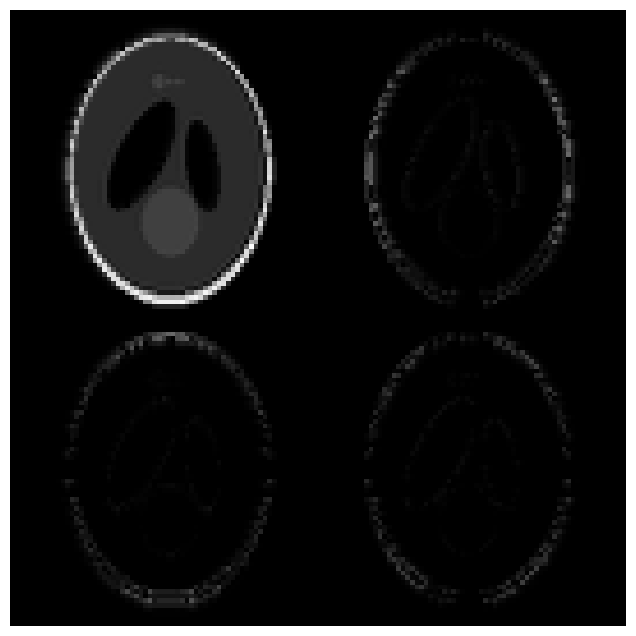

In [10]:
import pywt

coeffs = pywt.wavedecn(phan, 'db4', mode='zero', axes=(-2, -1), level=1)

output, _ = pywt.coeffs_to_array(coeffs, axes=(-2, -1))
print(output.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(abs(output), cmap='gray', interpolation=None)
ax.set_axis_off()

### Total Variation Transform

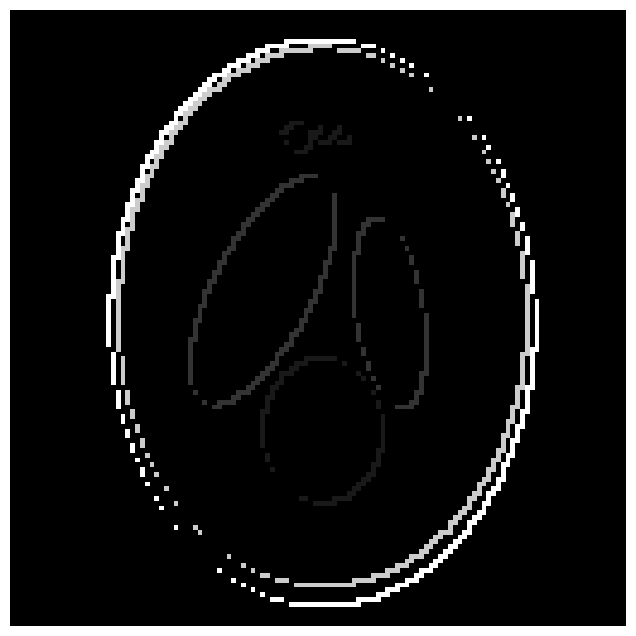

In [11]:
tvar = phan - np.roll(phan, 1, axis=(-2, -1))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(abs(tvar), cmap='gray', interpolation=None)
ax.set_axis_off()

## Non-Uniform Sampling

In [12]:
orig_ksp = sp.fft(phan, axes=(-2, -1))

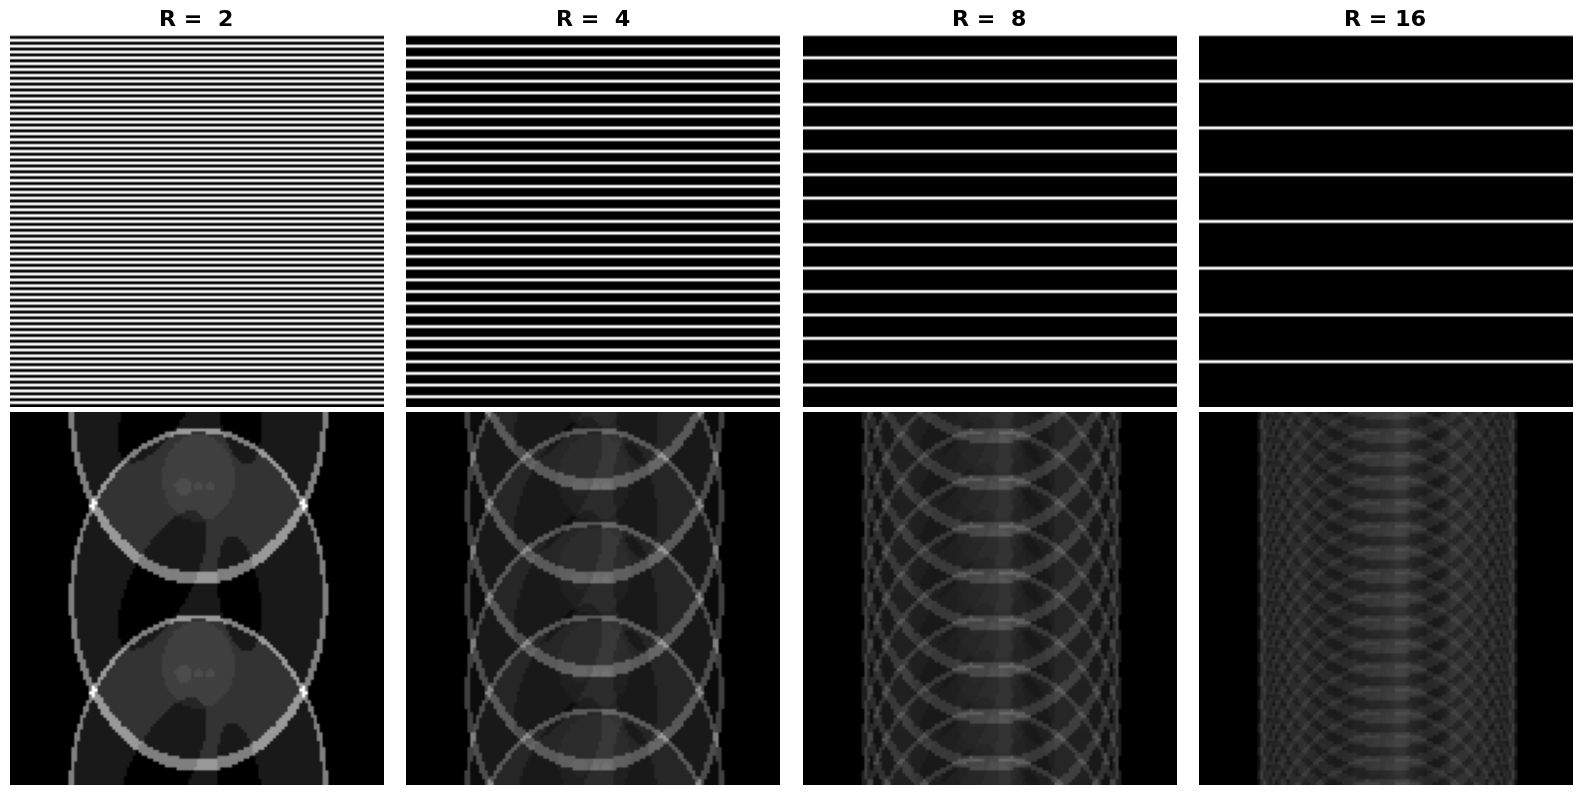

In [13]:
R_cartes = [2, 4, 8, 16]

N_row, N_col = 2, len(R_cartes)

fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4, N_row*4))

c = 0
for r in R_cartes:
  P = np.zeros_like(phan)
  P[::r, :] = 1
  I = sp.ifft(P * orig_ksp, axes=(-2, -1))


  ax[0, c].imshow(abs(P), cmap='gray', interpolation=None, vmin=0, vmax=1)
  ax[1, c].imshow(abs(I), cmap='gray', interpolation=None, vmin=0, vmax=1)

  ax[0, c].set_title('R = %2d'%(r), fontsize=16, color='k', weight='bold')

  for r in range(N_row):
    ax[r,c].set_axis_off()

  c += 1

plt.tight_layout()
plt.show()

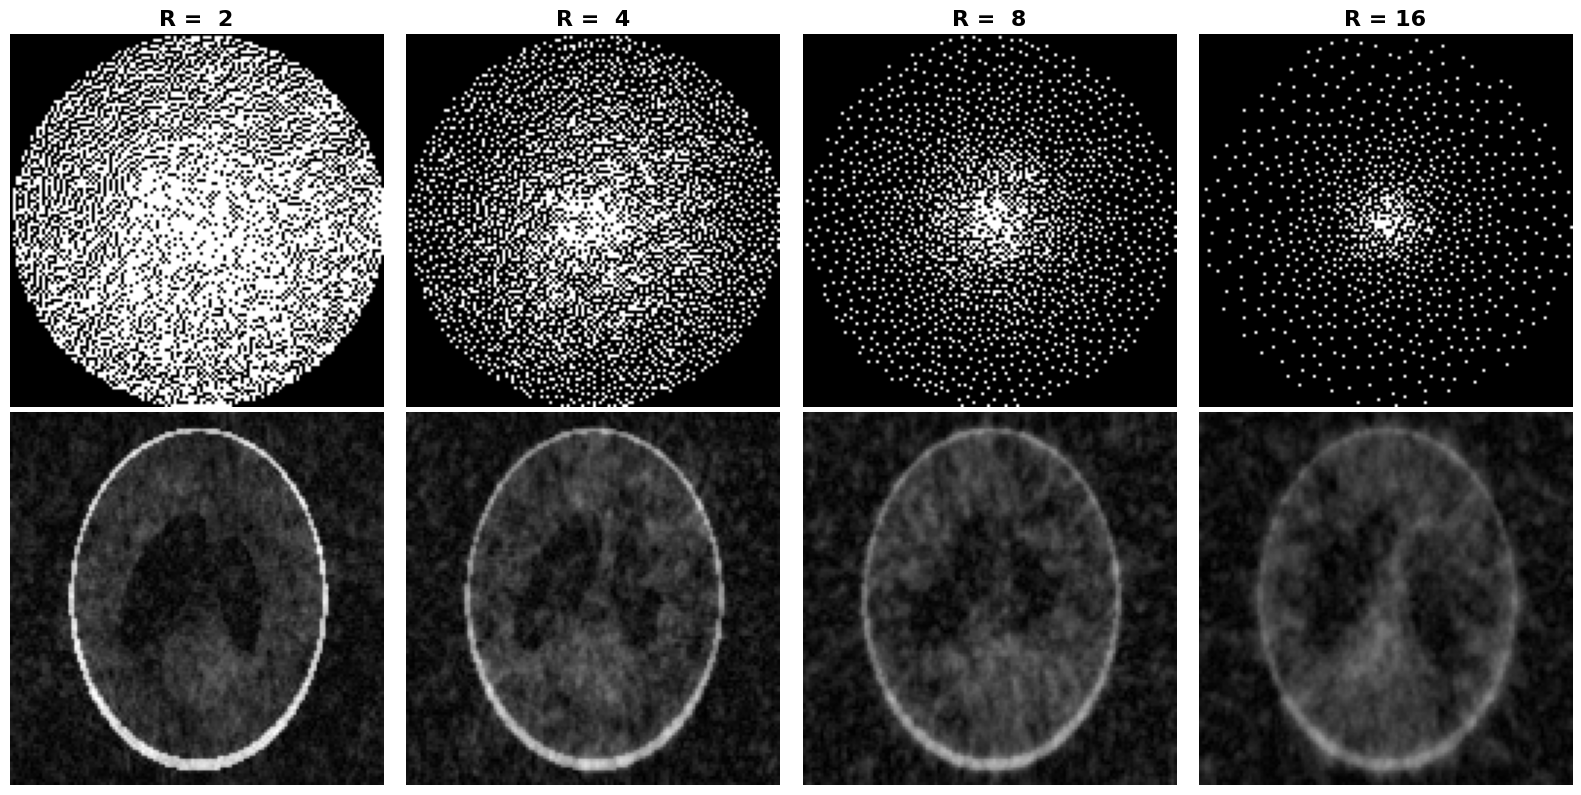

In [14]:
R_poisson = [2, 4, 8, 16]

N_row, N_col = 2, len(R_poisson)

fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4, N_row*4))

c = 0
for r in R_poisson:
  P = samp.poisson((N_y, N_x), r)
  I = sp.ifft(P * orig_ksp, axes=(-2, -1))

  ax[0, c].imshow(abs(P), cmap='gray', interpolation=None, vmin=0, vmax=1)
  ax[1, c].imshow(abs(I), cmap='gray', interpolation=None, vmin=0, vmax=1)

  ax[0, c].set_title('R = %2d'%(r), fontsize=16, color='k', weight='bold')

  for r in range(N_row):
    ax[r,c].set_axis_off()

  c += 1

plt.tight_layout()
plt.show()

>>> traj shape:  (100, 256, 2)
>>> traj shape:  (50, 256, 2)
>>> traj shape:  (12, 256, 2)
>>> traj shape:  (4, 256, 2)


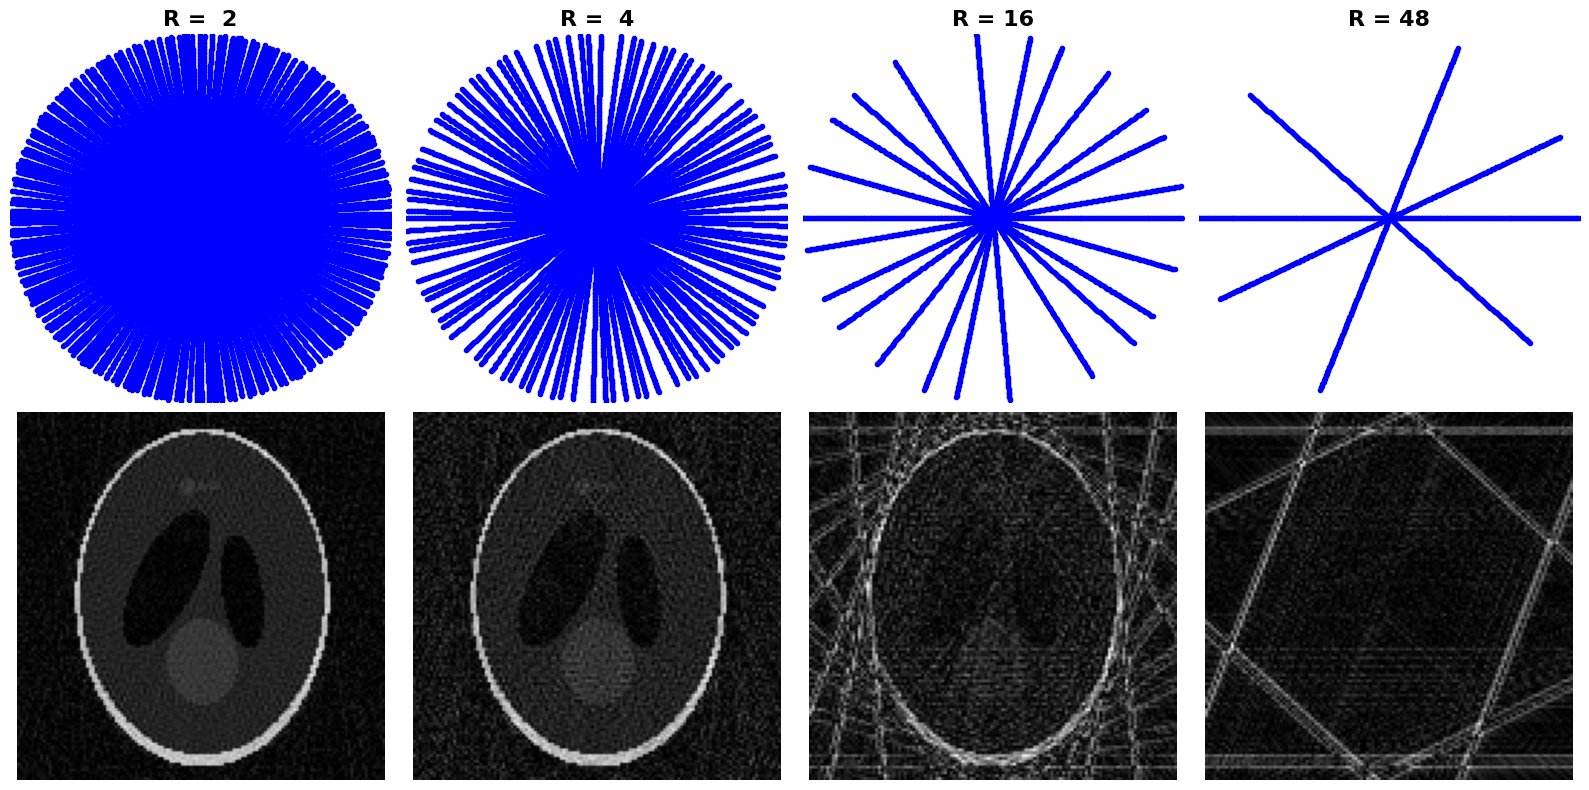

In [15]:
def _radial_usamp(input, R=1):
  N_y, N_x = input.shape

  N_spokes = int(N_x * np.pi/2 / R)
  base_res = N_x
  N_samples = base_res * 2

  base_lin = np.arange(N_samples).reshape(1, -1) - base_res

  tau = 0.5 * (1 + 5**0.5)
  base_rad = np.pi / (2 + tau - 1)

  base_rot = np.arange(N_spokes).reshape(-1, 1) * base_rad

  traj = np.zeros((N_spokes, N_samples, 2))
  traj[..., 0] = np.cos(base_rot) @ base_lin
  traj[..., 1] = np.sin(base_rot) @ base_lin

  traj = traj / 2

  print('>>> traj shape: ', traj.shape)

  F = sp.linop.NUFFT([N_y, N_x], traj)
  dcf = (traj[..., 0]**2 + traj[..., 1]**2)**0.5

  tmp = F * input
  I = F.H * (dcf * tmp)

  return traj, I

R_radial = [2, 4, 16, 48]

N_row, N_col = 2, len(R_radial)
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4, N_row*4))

c = 0
for r in R_radial:

  traj, I = _radial_usamp(phan, r)

  ax[0, c].plot(traj[:, :, 0], traj[:, :, 1], '.b')
  ax[0, c].set_xlim([-N_x//2, N_x//2])
  ax[0, c].set_ylim([-N_x//2, N_x//2])
  ax[1, c].imshow(abs(I), cmap='gray', interpolation=None)

  ax[0, c].set_title('R = %2d'%(r), fontsize=16, color='k', weight='bold')

  for r in range(N_row):
    ax[r,c].set_axis_off()

  c += 1

plt.tight_layout()
plt.show()

>>> traj shape:  (4781, 2)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

>>> dcf shape:  (4781,)
>>> traj shape:  (2376, 2)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

>>> dcf shape:  (2376,)
>>> traj shape:  (573, 2)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

>>> dcf shape:  (573,)
>>> traj shape:  (171, 2)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

>>> dcf shape:  (171,)


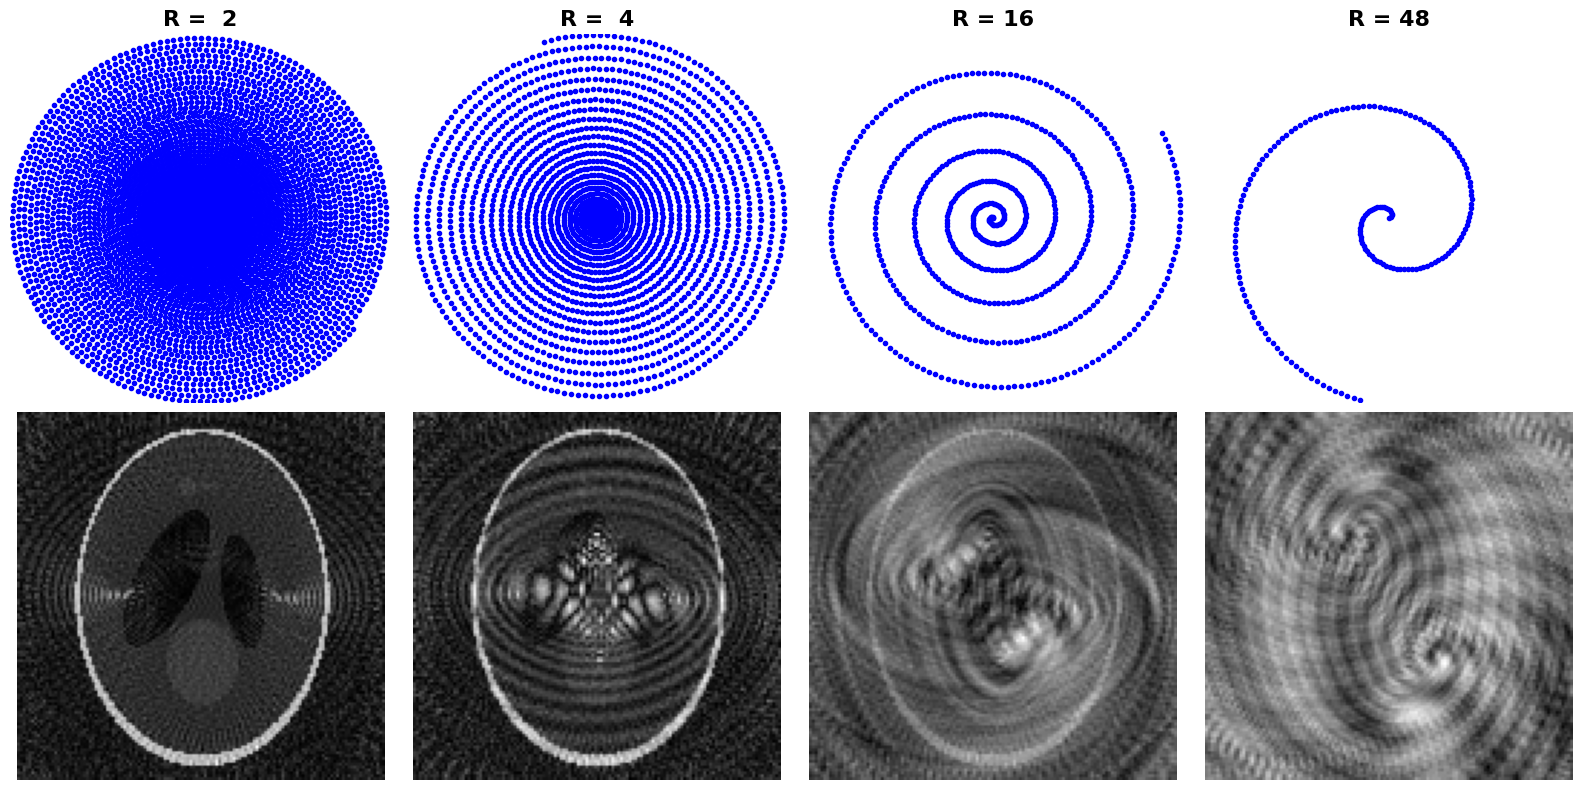

In [16]:
def _spiral_usamp(input, R=1):
  N_y, N_x = input.shape

  traj = samp.spiral(128E-3, 128, 1.2, R, 1, 1.6, 0.054, 150)
  tmax = np.max((traj[..., 0]**2 + traj[..., 1]**2)**0.5)
  traj = traj / tmax * N_x/2

  print('>>> traj shape: ', traj.shape)

  dcf = sp.mri.dcf.pipe_menon_dcf(traj, img_shape=[N_y, N_x])
  print('>>> dcf shape: ', dcf.shape)

  F = sp.linop.NUFFT([N_y, N_x], traj)

  tmp = F * input
  I = F.H * (dcf * tmp)

  return traj, I


R_spiral = [2, 4, 16, 48]

N_row, N_col = 2, len(R_spiral)
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4, N_row*4))

c = 0
for r in R_spiral:

  traj, I = _spiral_usamp(phan, r)

  ax[0, c].plot(traj[:, 0], traj[:, 1], '.b')
  ax[0, c].set_xlim([-N_x//2, N_x//2])
  ax[0, c].set_ylim([-N_x//2, N_x//2])
  ax[1, c].imshow(abs(I), cmap='gray', interpolation=None)

  ax[0, c].set_title('R = %2d'%(r), fontsize=16, color='k', weight='bold')

  for r in range(N_row):
    ax[r,c].set_axis_off()

  c += 1

plt.tight_layout()
plt.show()

### Point Spread Function (PSF)

>>> traj shape:  (25, 256, 2)
>>> traj shape:  (1174, 2)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

>>> dcf shape:  (1174,)


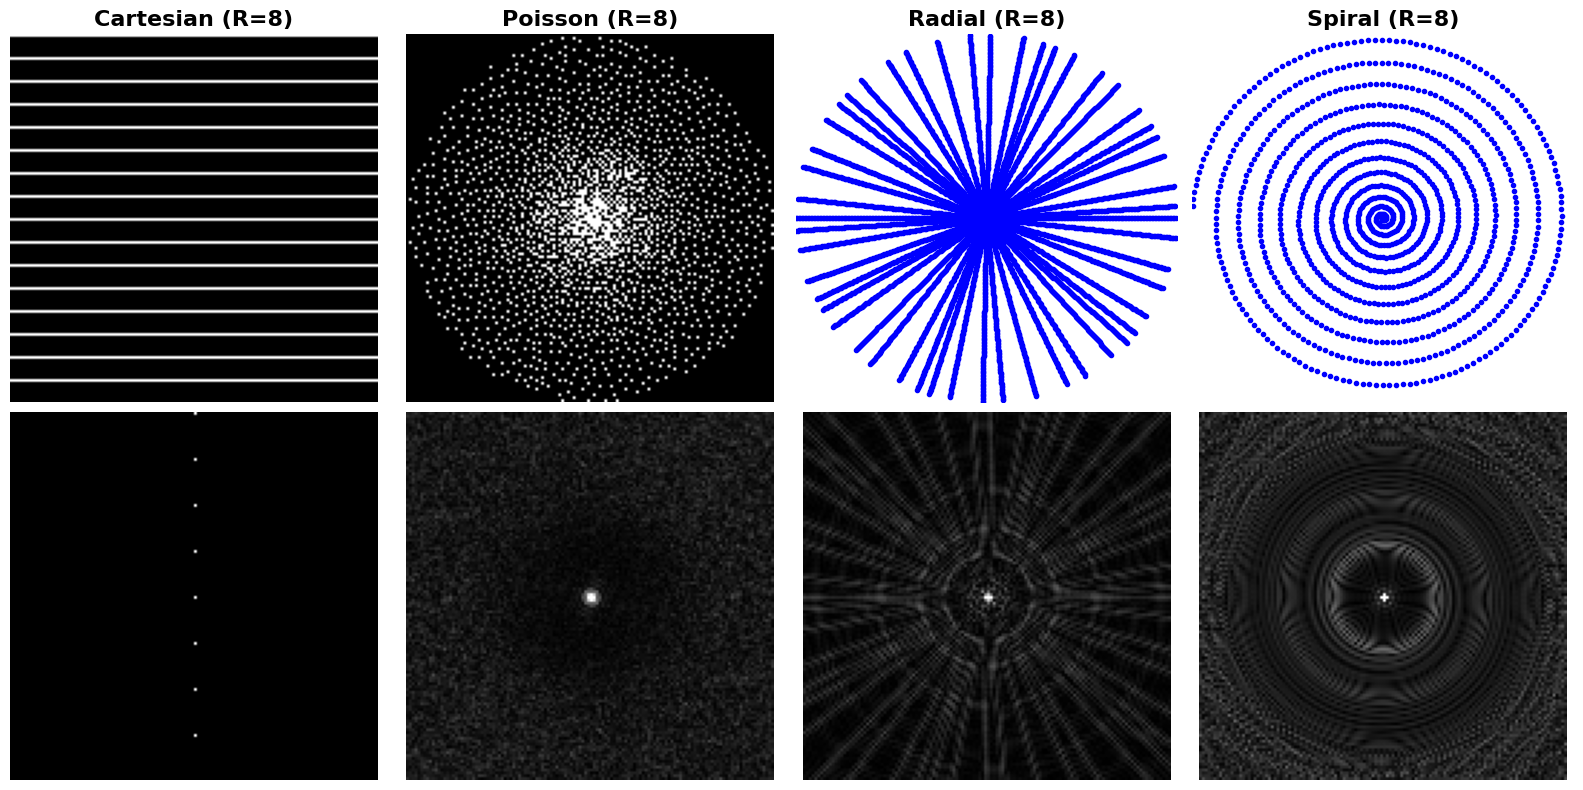

In [17]:
R = 8

src = np.zeros_like(phan)
src[N_y//2, N_x//2] = 1
K = sp.fft(src, axes=(-2, -1))

samp_list = ['Cartesian', 'Poisson', 'Radial', 'Spiral']

N_row, N_col = 2, len(samp_list)
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4, N_row*4))
c = 0
for s in samp_list:

  if s == 'Cartesian':
    P = np.zeros_like(phan)
    P[::R, :] = 1
    psf = sp.ifft(P * K, axes=(-2, -1))

  elif s == 'Poisson':
    P = samp.poisson((N_y, N_x), R)
    psf = sp.ifft(P * K, axes=(-2, -1))

  elif s == 'Radial':
    traj, psf = _radial_usamp(src, R)

  elif s == 'Spiral':
    traj, psf = _spiral_usamp(src, R)


  if s == 'Cartesian' or s == 'Poisson':
    ax[0, c].imshow(abs(P), cmap='gray', interpolation=None, vmin=0, vmax=1)
  else:
    traj_plot = np.reshape(traj, (-1, 2))
    ax[0, c].plot(traj_plot[:, 0], traj_plot[:, 1], '.b')
    ax[0, c].set_xlim([-N_x//2, N_x//2])
    ax[0, c].set_ylim([-N_x//2, N_x//2])

  ax[1, c].imshow(abs(psf), cmap='gray', interpolation=None,
                  vmin=0, vmax=np.max(abs(psf))*0.2)

  ax[0, c].set_title(s + ' (R=%d)'%(R), fontsize=16, weight='bold')

  for r in range(N_row):
    ax[r,c].set_axis_off()

  c += 1

plt.tight_layout()
plt.show()

## Compressed Sensing Reconstruction

>>> traj shape:  (2376, 2)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

>>> dcf shape:  (2376,)
>>> ksp shape:  (4, 2376)
>>> NUFFT  (128, 128)


SenseRecon:   0%|          | 0/60 [00:00<?, ?it/s]

>>> SENSE  (128, 128)


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/700 [00:00<?, ?it/s]

>>> traj shape:  (1174, 2)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

>>> dcf shape:  (1174,)
>>> ksp shape:  (4, 1174)
>>> NUFFT  (128, 128)


SenseRecon:   0%|          | 0/60 [00:00<?, ?it/s]

>>> SENSE  (128, 128)


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/700 [00:00<?, ?it/s]

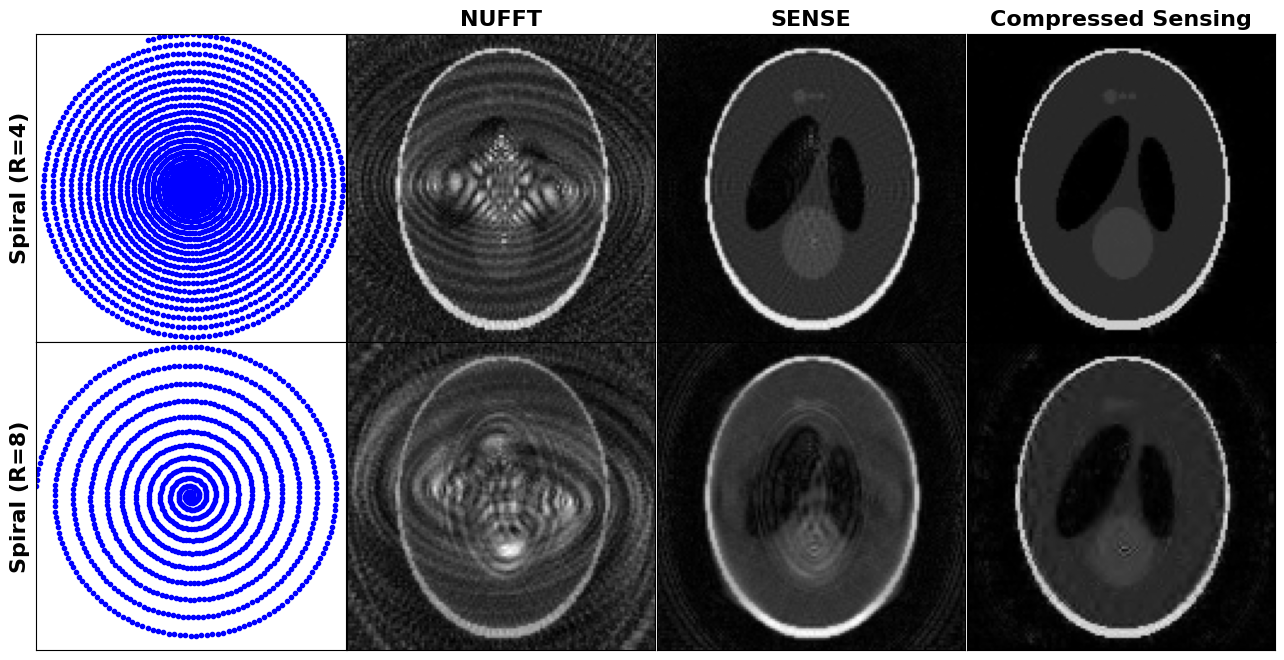

In [18]:
from sigpy.mri import sim, app

N_c = 4
coil = sim.birdcage_maps((N_c, N_y, N_x))

accel = [4, 8]

N_row, N_col = len(accel), 4
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4, N_row*4))

for cnt in range(N_row):

  traj = samp.spiral(128E-3, 128, 1.2, accel[cnt], 1, 1.6, 0.054, 150)
  tmax = np.max((traj[..., 0]**2 + traj[..., 1]**2)**0.5)
  traj = traj / tmax * N_x/2

  print('>>> traj shape: ', traj.shape)

  dcf = sp.mri.dcf.pipe_menon_dcf(traj, img_shape=[N_y, N_x])
  print('>>> dcf shape: ', dcf.shape)

  F = sp.linop.NUFFT([N_c, N_y, N_x], traj)

  ksp = F * (coil * phan)
  print('>>> ksp shape: ', ksp.shape)

  R_NUFFT = F.H * (dcf * ksp)
  R_NUFFT = sp.rss(R_NUFFT, axes=(0,))
  print('>>> NUFFT ', R_NUFFT.shape)

  # %% SENSE
  R_PI = app.SenseRecon(ksp, coil, lamda=0.002, max_iter=60, coord=traj,
                        device=device).run()
  R_PI = sp.to_device(R_PI)
  print('>>> SENSE ', R_PI.shape)

  # %% CS
  R_CS = app.L1WaveletRecon(ksp, coil, lamda=1E-4, max_iter=700,
                            coord=traj,
                            device=device).run()
  R_CS = sp.to_device(R_CS)

  ax[cnt,0].plot(traj[:, 0], traj[:, 1], '.b')
  ax[cnt,0].set_xlim([-N_x//2, N_x//2])
  ax[cnt,0].set_ylim([-N_x//2, N_x//2])
  ax[cnt,0].set_ylabel('Spiral (R=%1d)'%(accel[cnt]),
                       fontsize=16, weight='bold')

  ax[cnt,1].imshow(abs(R_NUFFT), cmap='gray', interpolation=None)
  ax[0,1].set_title('NUFFT', fontsize=16, weight='bold')
  ax[cnt,2].imshow(abs(R_PI), cmap='gray', interpolation=None)
  ax[0,2].set_title('SENSE', fontsize=16, weight='bold')
  ax[cnt,3].imshow(abs(R_CS), cmap='gray', interpolation=None)
  ax[0,3].set_title('Compressed Sensing', fontsize=16, weight='bold')

  for n in range(N_col):
    ax[cnt,n].set_xticks([])
    ax[cnt,n].set_yticks([])

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

## Low Rank

In [19]:
N_frame, N_z, N_y, N_x = 200, 1, 128, 128

dyn_phan = sp.sim.dynamic_shepp_logan([N_frame, N_z, N_y, N_x])

print(dyn_phan.shape)

(200, 1, 128, 128)


In [20]:
import pathlib
pathlib.Path('dyn_phan').mkdir(parents=True, exist_ok=True)

from google.colab import files
import shutil

from matplotlib.patches import Rectangle

blk = 15
y0, x0 = int(N_y*0.66), int(N_x*0.52)

for f in range(N_frame):

  fig, ax = plt.subplots(1, 1, figsize=(4,4))
  ax.imshow(abs(dyn_phan[f, 0]), cmap='gray', interpolation=None)

  Rect = Rectangle((0, 0), N_y-1, N_x-1, edgecolor='#00274C',
                   facecolor='none', linewidth=2)
  ax.add_patch(Rect)

  Rect = Rectangle((x0, y0), blk, blk, edgecolor='#FFCB05',
                   facecolor='none', linewidth=2)
  ax.add_patch(Rect)

  ax.set_axis_off()
  plt.savefig('dyn_phan/frame_' + str(f).zfill(3) + '.png',
              bbox_inches='tight', pad_inches=0, dpi=300)
  plt.close()

shutil.make_archive('dyn_phan', 'zip', 'dyn_phan')

'/content/sigpy/dyn_phan.zip'

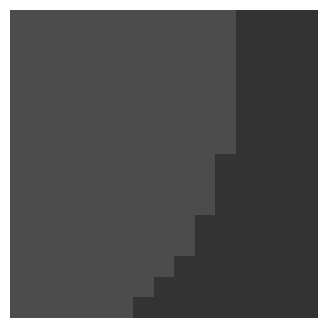

(200, 225)


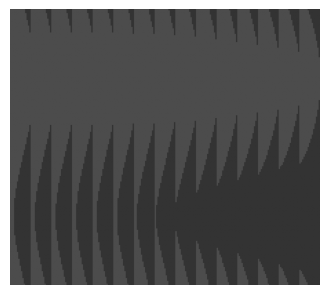

(200, 16384)


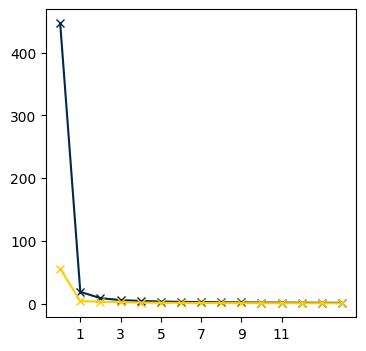

In [21]:
dyn_phan_sub = dyn_phan[:, :, y0 : y0 + blk, x0 : x0 + blk]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(abs(dyn_phan_sub[0, 0]), cmap='gray', interpolation=None,
          vmin=0, vmax=1)
ax.set_axis_off()
plt.show()

dyn_phan_sub_2 = np.reshape(dyn_phan_sub, (N_frame, -1))
print(dyn_phan_sub_2.shape)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(abs(dyn_phan_sub_2), cmap='gray', interpolation=None,
          vmin=0, vmax=1)
ax.set_axis_off()
plt.show()



dyn_phan_2 = np.reshape(dyn_phan, (N_frame, -1))
print(dyn_phan_2.shape)

_, s_glo, _ = np.linalg.svd(dyn_phan_2, full_matrices=False)

_, s_loc, _ = np.linalg.svd(dyn_phan_sub_2, full_matrices=False)


fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(abs(s_glo[:15]), '-x', color='#00274C')
ax.plot(abs(s_loc[:15]), '-x', color='#FFCB05')
ax.set_xticks([1, 3, 5, 7, 9, 11])
plt.show()

## SPIRiT

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import sigpy as sp

from scipy.io import loadmat
from sigpy.mri import sim, app

import h5py
import os

device = sp.Device(0)
print('> device: ', device)

> device:  <CUDA Device 0>


### Load Brain Data

In [24]:
out_dir = '../teach_umich_bme599_advanced-topics-mri/2025_image_recon_2_cslr/demo/'
file_name = out_dir + '/brain_alias_8ch.mat'

f = loadmat(file_name)
ksp = f['DATA'][:].T

print('> ksp: ', ksp.shape)
N_c, N_y, N_x = ksp.shape

> ksp:  (8, 256, 320)


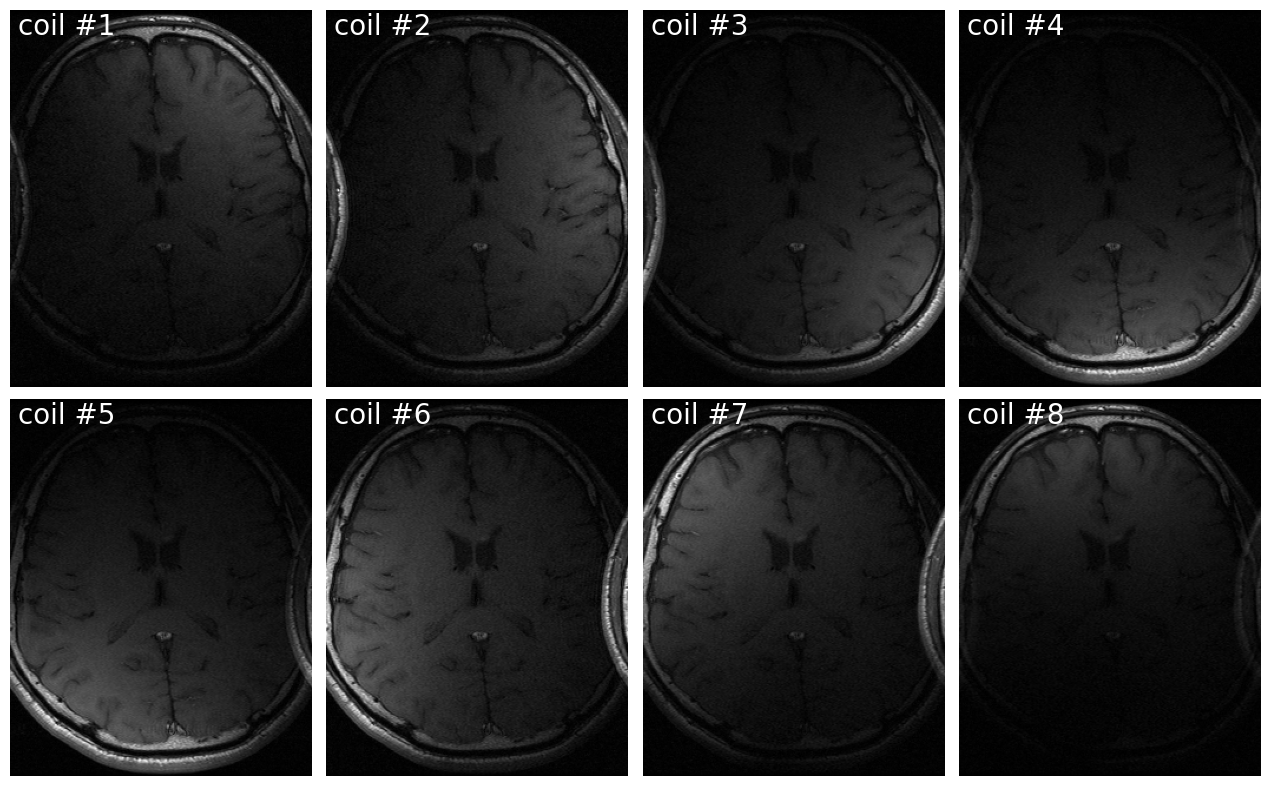

In [25]:
orig_img = sp.ifft(ksp, axes=(-2, -1))

N_row, N_col = 2, 4
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4*N_y/N_x, N_row*4))

for m in range(N_row):
    for n in range(N_col):
        idx = m*N_col+n
        img = np.swapaxes(orig_img[idx, :, :], -2, -1)
        ax[m, n].imshow(abs(img), cmap='gray', interpolation=None)
        ax[m, n].text(0.02*N_x, 0.08*N_y, 'coil #%1d'%(idx + 1),
                      fontsize=20, color='w')
        ax[m, n].set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_coil_images.png', dpi=300)

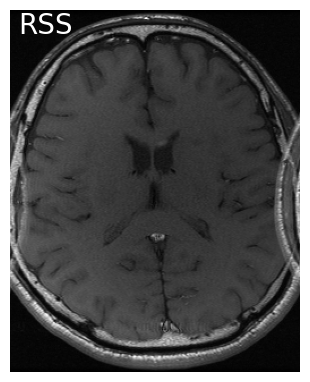

In [26]:
orig_img_rss = sp.rss(orig_img, axes=0)

fig, ax = plt.subplots(1, 1, figsize=(N_y/N_x*4, 4))

img = np.swapaxes(orig_img_rss, -2, -1)
ax.imshow(abs(img), cmap='gray', interpolation=None)
ax.text(0.02*N_x, 0.08*N_y, 'RSS',
        fontsize=20, color='w')
ax.set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_rss.png', dpi=300)

### Undersampling the k-Space Data

In [27]:
P = np.zeros_like(ksp, shape=(N_y, N_x))
P[::2, :] = 1  # 1D undersampling

ksp_usamp = P * ksp

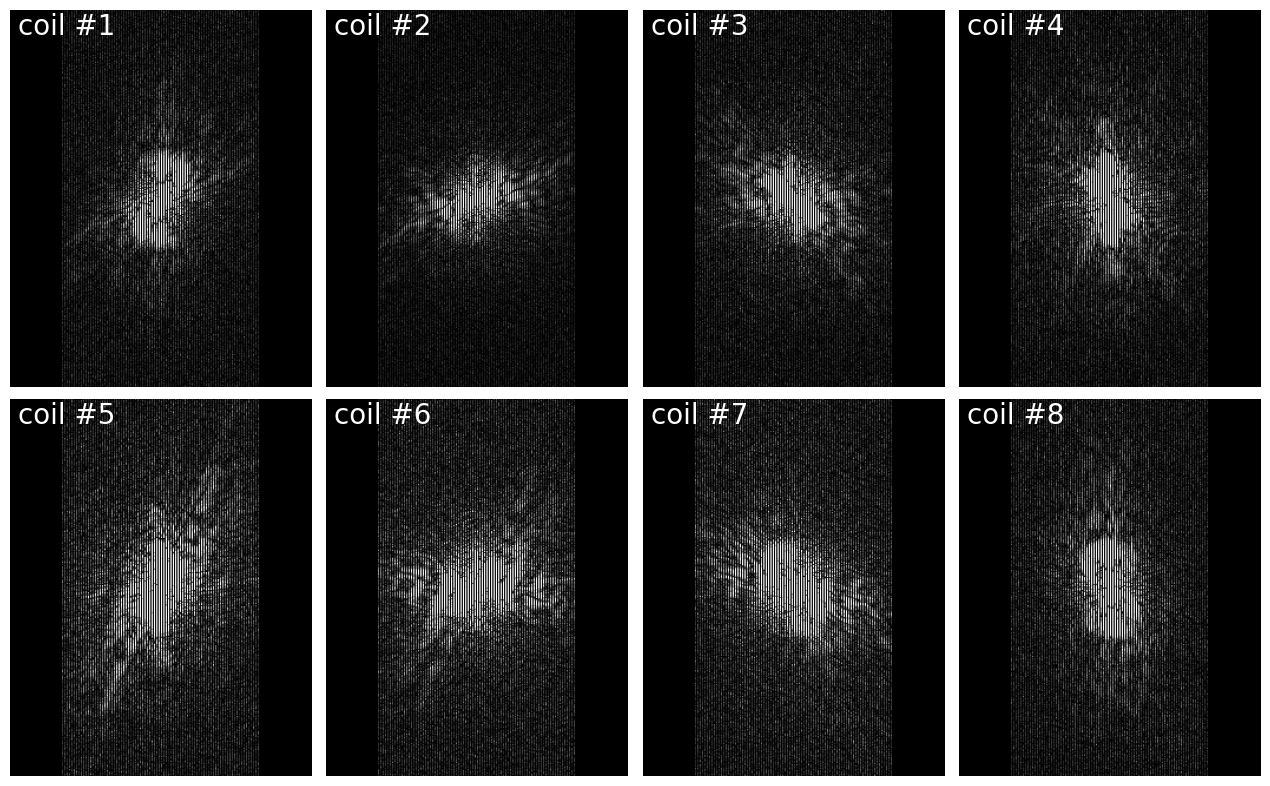

In [28]:
N_row, N_col = 2, 4
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4*N_y/N_x, N_row*4))

vmax = np.max(abs(ksp_usamp))

for m in range(N_row):
    for n in range(N_col):
        idx = m*N_col+n
        img = np.swapaxes(ksp_usamp[idx, :, :], -2, -1)
        ax[m, n].imshow(abs(img), cmap='gray', interpolation=None,
                        vmin=0, vmax=vmax*0.005)
        ax[m, n].text(0.02*N_x, 0.08*N_y, 'coil #%1d'%(idx + 1),
                      fontsize=20, color='w')
        ax[m, n].set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_undersampled_kspace.png', dpi=300)

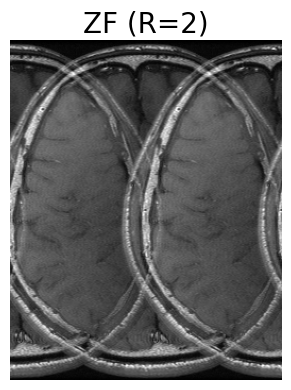

In [29]:
img_usamp_rss = sp.rss(sp.ifft(ksp_usamp, axes=(-2, -1)), axes=0)

fig, ax = plt.subplots(1, 1, figsize=(4*N_y/N_x, 4))

ax.imshow(abs(np.swapaxes(img_usamp_rss, -2, -1)), cmap='gray', interpolation=None)
ax.set_title('ZF (R=2)', fontsize=20)
ax.set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_zf.png', dpi=300)

### Use 1 Set of Coil Sensitivity Maps

In [30]:
sets = 1
mps = app.EspiritCalib(
    ksp, sets=sets, show_pbar=False
).run()

print('> mps: ', mps.shape)

if mps.shape[0] == 1:
    mps = np.squeeze(mps, axis=0)

self.mps  (320, 256, 8, 1)
self.max_eig  (1,)
> mps:  (1, 8, 256, 320)


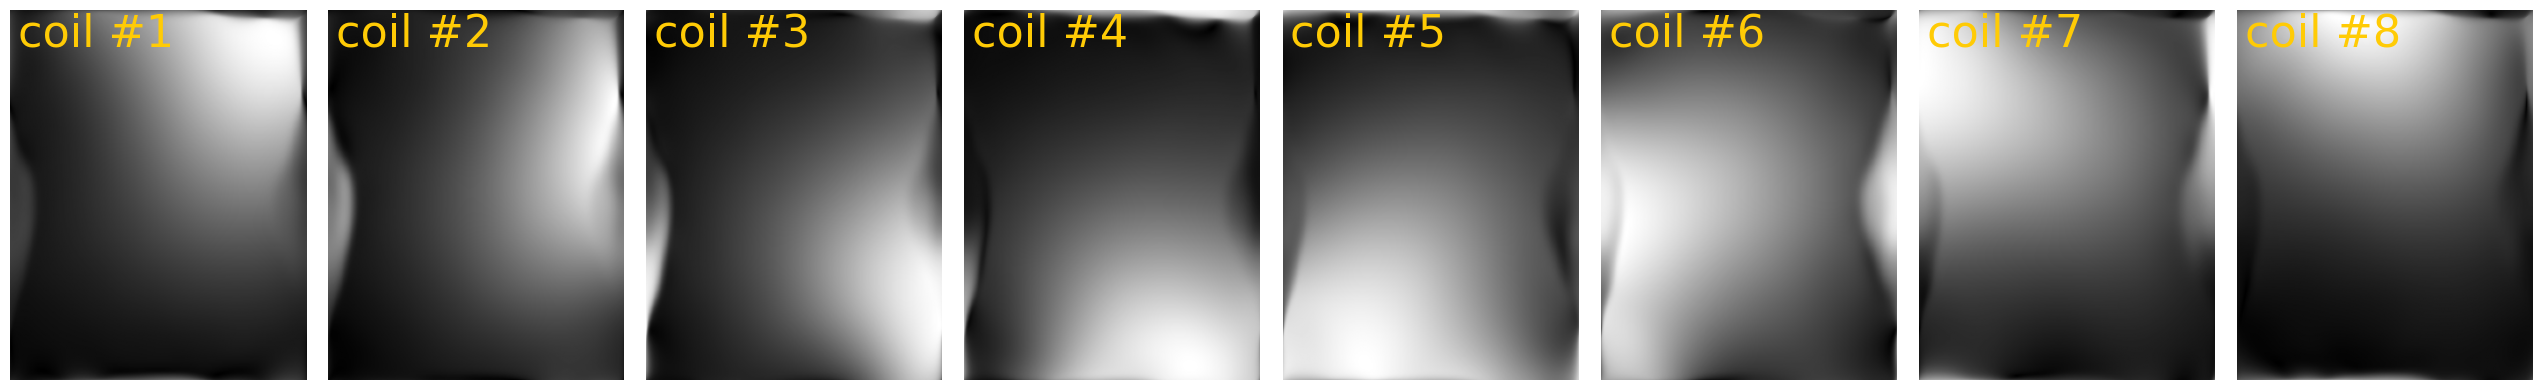

In [31]:
N_row, N_col = 1, N_c
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4*N_y/N_x, N_row*4))

for n in range(N_col):
    img = np.swapaxes(mps[n, :, :], -2, -1)
    ax[n].imshow(abs(img), cmap='gray', interpolation=None)
    ax[n].text(0.02*N_x, 0.12*N_y, 'coil #%1d'%(n + 1),
               fontsize=32, color='#FFCB05')
    ax[n].set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_coil1.png', dpi=300)

In [32]:
R_SENSE1 = app.SenseRecon(ksp_usamp, mps, lamda=0.01,
                          max_iter=60, device=device).run()
R_SENSE1 = sp.to_device(R_SENSE1)

SenseRecon:   0%|          | 0/60 [00:00<?, ?it/s]

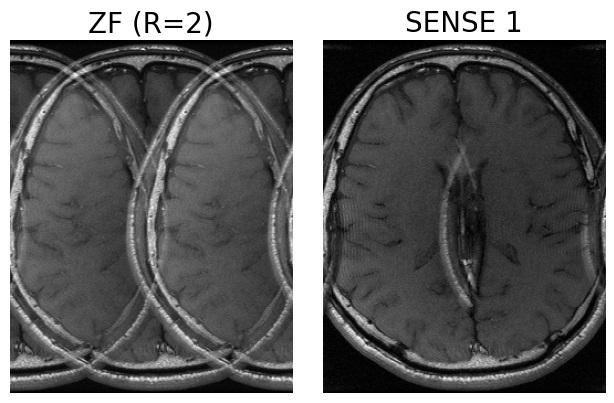

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(4*2*N_y/N_x, 4))

ax[0].imshow(abs(np.swapaxes(img_usamp_rss, -2, -1)), cmap='gray', interpolation=None)
ax[0].set_title('ZF (R=2)', fontsize=20)
ax[0].set_axis_off()

ax[1].imshow(abs(np.swapaxes(R_SENSE1, -2, -1)), cmap='gray', interpolation=None)
ax[1].set_title('SENSE 1', fontsize=20)
ax[1].set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_sense1.png', dpi=300)

### Use 2 Sets of Coil Sensitivity Maps

In [34]:
sets = 2
mps = app.EspiritCalib(
    ksp, sets=sets, show_pbar=False
).run()

print('> mps: ', mps.shape)

(320, 256, 8, 8) (320, 256, 8) (320, 256, 8, 8)
self.mps  (320, 256, 8, 2)
self.max_eig  (320, 256, 2)
> mps:  (2, 8, 256, 320)


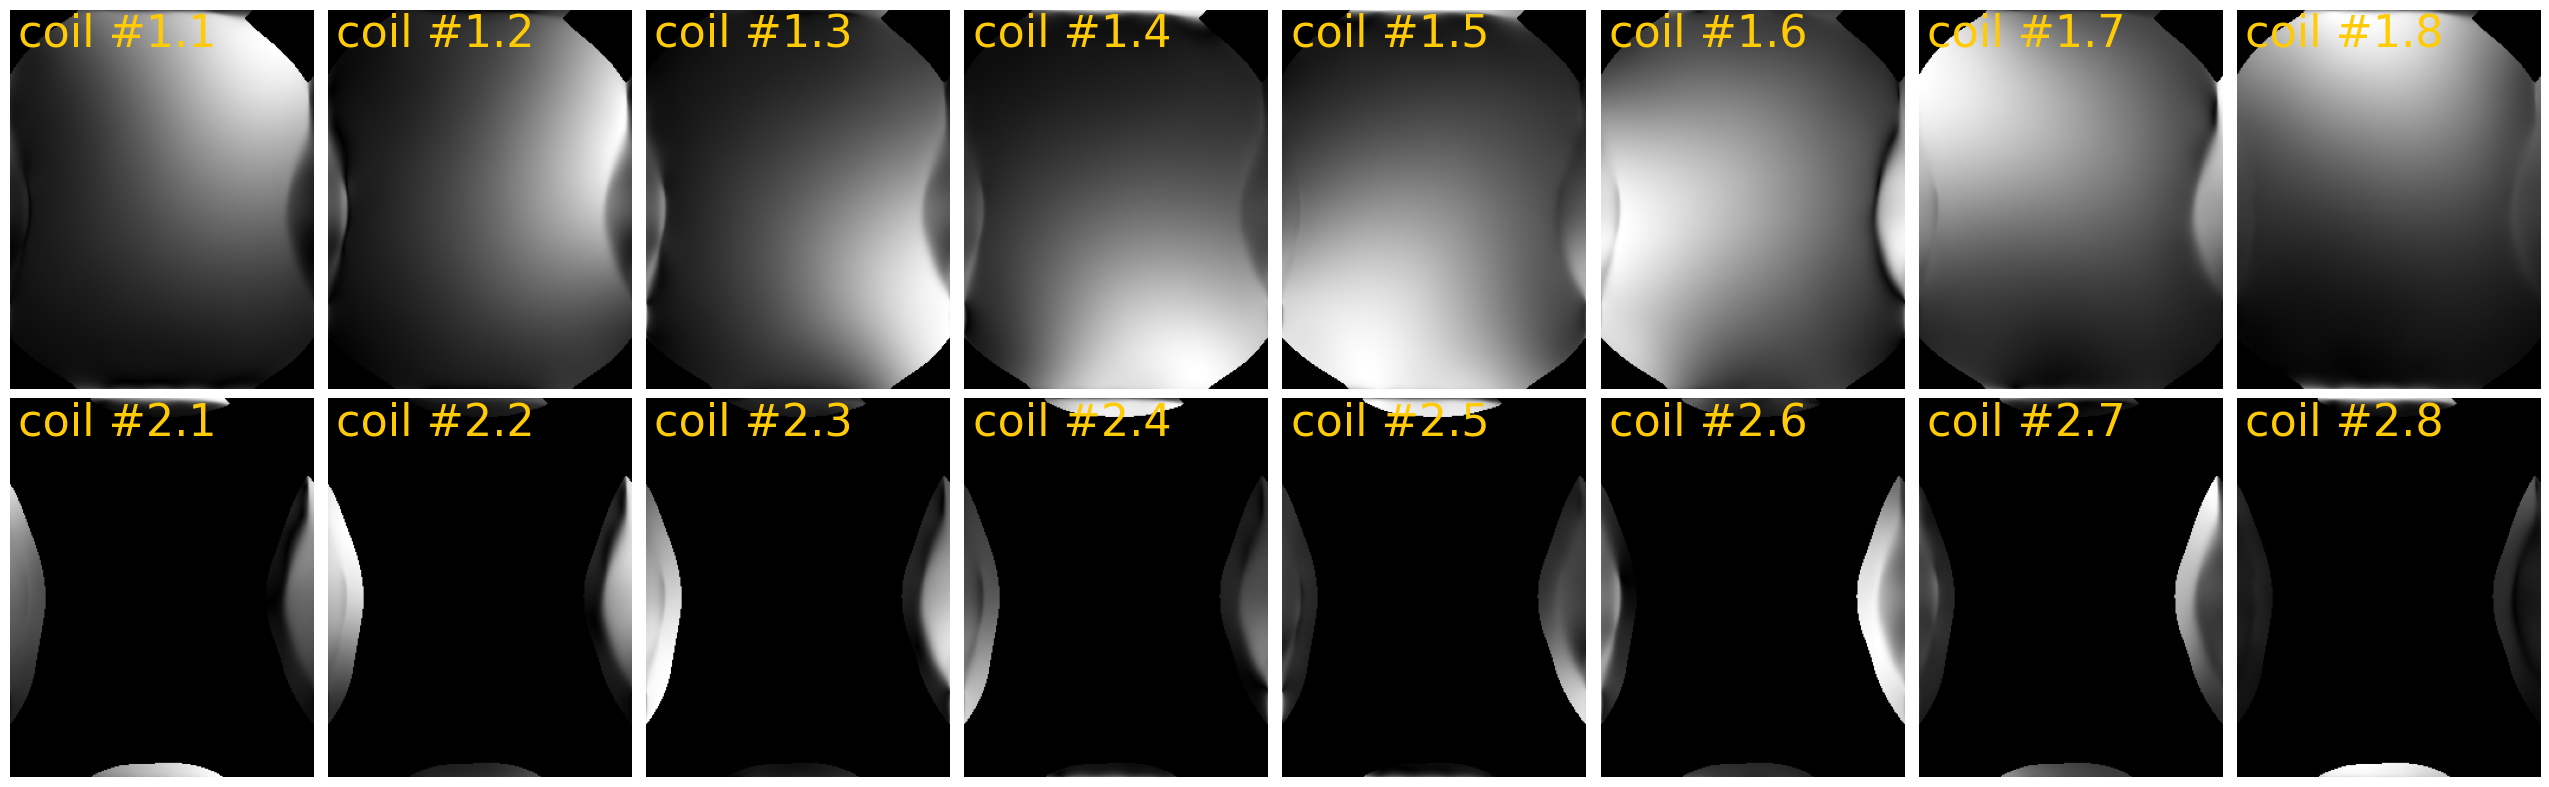

In [35]:
N_row, N_col = sets, N_c
fig, ax = plt.subplots(N_row, N_col, figsize=(N_col*4*N_y/N_x, N_row*4))

for m in range(N_row):
    for n in range(N_col):
        img = np.swapaxes(mps[m, n], -2, -1)
        ax[m,n].imshow(abs(img), cmap='gray', interpolation=None)
        ax[m,n].text(0.02*N_x, 0.12*N_y, 'coil #%1d.%1d'%(m+1, n+1),
                        fontsize=32, color='#FFCB05')
        ax[m,n].set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_coil2.png', dpi=300)

In [36]:
x_shape = [sets, 1, N_y, N_x]
C = sp.linop.Multiply(x_shape, mps)
S = sp.linop.Sum(C.oshape, axes=(0, ))
F = sp.linop.FFT(S.oshape, axes=(-2, -1))
P = sp.linop.Multiply(F.oshape, P)

A = P * F * S * C

AHA = lambda x: A.H * A * x + 0.01 * x
AHy = A.H * ksp_usamp

R_SENSE2 = np.zeros_like(ksp, shape=x_shape)
alg = sp.alg.ConjugateGradient(AHA, AHy, R_SENSE2,
                               max_iter=60,
                               verbose=True)

while (not alg.done()):
    alg.update()

  cg iter:  0; resid:   6829.985518; norm:  37557.467900
  cg iter:  1; resid:   3268.614505; norm:  44383.327814
  cg iter:  2; resid:   1882.714868; norm:  47537.692004
  cg iter:  3; resid:    501.767658; norm:  48630.525262
  cg iter:  4; resid:    486.881279; norm:  49038.585022
  cg iter:  5; resid:    110.496103; norm:  49180.502911
  cg iter:  6; resid:     78.054410; norm:  49204.937689
  cg iter:  7; resid:     15.946438; norm:  49209.469183
  cg iter:  8; resid:     15.878180; norm:  49210.103959
  cg iter:  9; resid:      4.434526; norm:  49210.449013
  cg iter: 10; resid:      3.485124; norm:  49210.531410
  cg iter: 11; resid:      0.771072; norm:  49210.547445
  cg iter: 12; resid:      0.665208; norm:  49210.549579
  cg iter: 13; resid:      0.181850; norm:  49210.550387
  cg iter: 14; resid:      0.167366; norm:  49210.550567
  cg iter: 15; resid:      0.042094; norm:  49210.550626
  cg iter: 16; resid:      0.031462; norm:  49210.550635
  cg iter: 17; resid:      0.00

In [37]:
print(R_SENSE2.shape)

(2, 1, 256, 320)


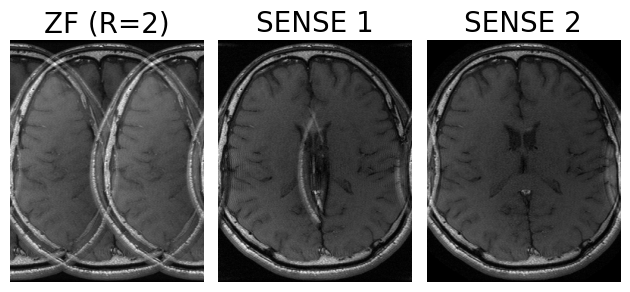

In [38]:
R_SENSE2_SUM = np.squeeze(np.sum(R_SENSE2, axis=0))

fig, ax = plt.subplots(1, 3, figsize=(4*2*N_y/N_x, 4))

ax[0].imshow(abs(np.swapaxes(img_usamp_rss, -2, -1)), cmap='gray', interpolation=None)
ax[0].set_title('ZF (R=2)', fontsize=20)
ax[0].set_axis_off()

ax[1].imshow(abs(np.swapaxes(R_SENSE1, -2, -1)), cmap='gray', interpolation=None)
ax[1].set_title('SENSE 1', fontsize=20)
ax[1].set_axis_off()

ax[2].imshow(abs(np.swapaxes(R_SENSE2_SUM, -2, -1)), cmap='gray', interpolation=None)
ax[2].set_title('SENSE 2', fontsize=20)
ax[2].set_axis_off()

plt.tight_layout()
plt.savefig(out_dir + '/espirit_sense2.png', dpi=300)

# Thank You for Your Attention !